# [Titanic](https://www.kaggle.com/c/titanic)


In [1]:
import pandas as pd
import numpy as np
np.random.seed(2018)

from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score

from sklearn.dummy import DummyClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, AdaBoostClassifier
from sklearn import svm,model_selection, tree, linear_model, neighbors, naive_bayes, ensemble, discriminant_analysis, gaussian_process

import xgboost as xgb

from collections import defaultdict

import helper as h

import matplotlib.pyplot as plt
%matplotlib inline

## Load data

In [2]:
df_train = pd.read_csv('../input/titanic.train.csv')
df_test = pd.read_csv('../input/titanic.test.csv')

df_all = pd.concat([df_train, df_test])

## Data analysis

In [48]:
print(df_train.shape)
print(df_test.shape)

(891, 12)
(418, 11)


In [49]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB


In [50]:
df_train.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [51]:
df_train.sample(2)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
438,439,0,1,"Fortune, Mr. Mark",male,64.0,1,4,19950,263.00,C23 C25 C27,S
283,284,1,3,"Dorking, Mr. Edward Arthur",male,19.0,0,0,A/5. 10482,8.05,NaN,S


In [52]:
df_train.pivot_table(values=["Survived"], index=["Pclass","Sex"], aggfunc=np.mean)

Survived
Pclass Sex             
1      female  0.968085
       male    0.368852
2      female  0.921053
       male    0.157407
3      female  0.500000
       male    0.135447

## First dummy sample - ASAP to kaggle
### Kaggle score 65%

In [53]:
feats = [ 'Pclass' ]

X = df_train[ feats ].values
y = df_train['Survived'].values

In [54]:
model = ExtraTreesClassifier(n_estimators=100, max_depth=4)
model.fit(X, y)
y_pred = model.predict(X)

score = accuracy_score(y, y_pred)

In [55]:
X = df_test[ feats ].values

predictions = df_test['Survived'] = model.predict(X)

PassengerId = df_test['PassengerId']

submission = pd.DataFrame({ 'PassengerId': PassengerId, 'Survived': predictions })
submission.to_csv("../output/extra_tree_1_feature.csv", index=False)

print("Our features: %s" % feats)
print("score %.2f" % score)

Our features: ['Pclass']
score 0.68


## Second dummy sample - ASAP to kaggle
### Kaggle score 67%

In [56]:
feats = df_train.select_dtypes(include=[np.int64]).columns.values
black_list = ['PassengerId', 'Survived'] 

feats = [feat for feat in feats if feat not in black_list]

In [57]:
X = df_train[ feats ].values
y = df_train['Survived'].values

model = ExtraTreesClassifier(n_estimators=100, max_depth=4)
model.fit(X, y)
y_pred = model.predict(X)

score = accuracy_score(y, y_pred)

In [58]:
X = df_test[ feats ].values

predictions = df_test['Survived'] = model.predict(X)

PassengerId = df_test['PassengerId']

submission = pd.DataFrame({ 'PassengerId': PassengerId, 'Survived': predictions })
submission.to_csv("../output/extra_tree_int64_features.csv", index=False)

print("Our features: %s" % feats)
print("score %.2f" % score)

Our features: ['Pclass', 'SibSp', 'Parch']
score 0.71


## Create few helpers

In [59]:
black_list = ['PassengerId', 'Survived']
PassengerId = df_test['PassengerId']


In [85]:
def get_feats(df):
    feats = df.select_dtypes(include=[np.int64]).columns.values
    black_list = ['PassengerId', 'Survived']
    
    return [feat for feat in feats if feat not in black_list]

def train_and_predict():
    feats = get_feats( df_train.select_dtypes(include=[np.int, np.float]).head() )
    print('Our features: %s ' % feats)

    X = df_train[ feats ].values
    y = df_train['Survived'].values

    model = RandomForestClassifier(max_depth=3, n_estimators=100, random_state=1)

    model.fit(X, y)
    y_pred = model.predict(X)

    score = accuracy_score(y, y_pred)
    
    print('Score %s' %score)
    
    return model
        

def predict_and_submit(model, feats, file_name):
    predictions = df_test[ 'Survived' ] = model.predict( df_test[ feats ].values )

    submission = pd.DataFrame({ 'PassengerId': PassengerId, 'Survived': predictions })
    submission.to_csv( '../output/' + file_name + '.csv', index=False )

def feature_engineering(df):
    
    df['name_length'] = df['Name'].apply(len)

    df['sex_cat'] = pd.factorize( df['Sex'] )[0]
    df['embarked_cat'] = pd.factorize( df['Embarked'].fillna('C') )[0]
    df['title'] = df['Name'].map(lambda x: x.split(',')[1].split('.')[0].strip())
    rare_titles = ['Mlle','the Countess','Mme', 'Ms', 'Lady', 'Countess', 'Capt','Col','Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'] 
    df['title'].values[df['title'].isin( rare_titles )] = 'Rare'
    df['title_cat'] = df['title'].factorize()[0]

    return df

def train_predict_submit(file_name):
    feature_engineering(df_train)
    feature_engineering(df_test)
    
    predict_and_submit( train_and_predict() , get_feats(df_test) , file_name)

In [86]:
train_predict_submit('titanic_v3')

Our features: ['Pclass', 'SibSp', 'Parch', 'sex_cat', 'embarked_cat', 'name_length', 'title_cat'] 
Score 0.820426487093


## Feature Engineering

In [36]:
train['title'] = train['Name'].map(lambda x: x.split(',')[1].split('.')[0].strip())
train['title'].value_counts()

Mr              517
Miss            182
Mrs             125
Master           40
Dr                7
Rev               6
Mlle              2
Major             2
Col               2
Capt              1
Ms                1
Sir               1
Mme               1
Don               1
Lady              1
Jonkheer          1
the Countess      1
Name: title, dtype: int64

In [37]:
top_titles = list(train['title'].value_counts().head(6).keys())

title_norm = defaultdict(lambda: 'other', dict(zip(top_titles, top_titles)))
train['title_norm'] = train['title'].map(title_norm)
train['title_norm'].value_counts()

Mr        517
Miss      182
Mrs       125
Master     40
other      14
Dr          7
Rev         6
Name: title_norm, dtype: int64

In [38]:
train['title_cat'] = train['title'].factorize()[0]
train['title_norm_cat'] = train['title_norm'].factorize()[0]

### Model + title_norm

In [39]:
X, y = get_X_y(['Pclass', 'Age', 'SibSp', 'Parch', 'Fare', 'title_norm_cat'])
cross_val_score(DecisionTreeClassifier(max_depth=3, random_state=2018), X, y, scoring='accuracy', cv=3).mean()

0.8125701459034792

ValueError: Found input variables with inconsistent numbers of samples: [418, 891]

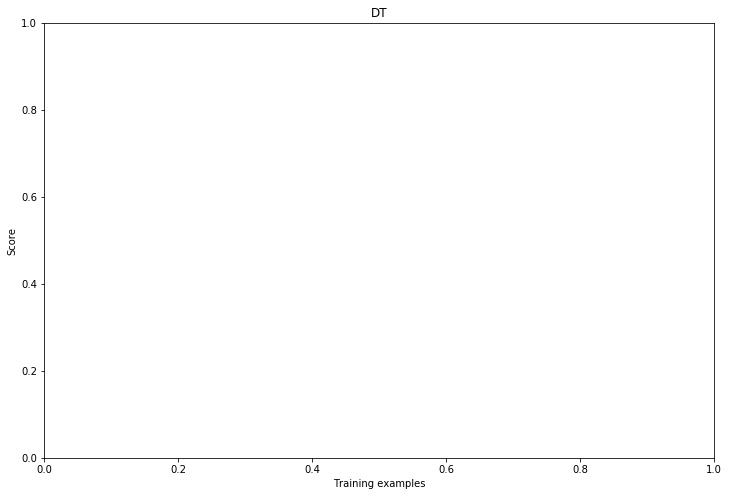

In [32]:
h.plot_learning_curve(DecisionTreeClassifier(max_depth=4, random_state=2018), 'DT', X, y);

## Age

In [41]:
dict_mean_age_by_title = train.groupby('title_norm_cat').agg(np.mean)['Age'].to_dict()
dict_median_age_by_title = train.groupby('title_norm_cat').agg(np.median)['Age'].to_dict()

In [42]:
dict_mean_age_by_title

{0: 32.368090452261306,
 1: 35.898148148148145,
 2: 21.773972602739725,
 3: 4.5741666666666667,
 4: 42.214285714285715,
 5: 43.166666666666664,
 6: 42.0}

In [43]:
dict_median_age_by_title

{0: 30.0, 1: 35.0, 2: 21.0, 3: 3.5, 4: 42.5, 5: 46.5, 6: 46.5}

In [45]:
train['age_mean'] = train.title_norm_cat.map(dict_mean_age_by_title)
train['age_median'] = train.title_norm_cat.map(dict_median_age_by_title)

In [46]:
X, y = get_X_y(['Pclass', 'title_norm_cat', 'SibSp', 'Parch', 'Fare', 'age_mean', 'age_median'])
cross_val_score(DecisionTreeClassifier(max_depth=4, random_state=2018), X, y, scoring='accuracy', cv=3).mean()

0.82042648709315369

## Family

In [47]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,title,title_norm,title_cat,title_norm_cat,age_mean,age_median
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,Mr,Mr,0,0,32.368090,30.0
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,Mrs,Mrs,1,1,35.898148,35.0
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,Miss,Miss,2,2,21.773973,21.0
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,Mrs,Mrs,1,1,35.898148,35.0
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,Mr,Mr,0,0,32.368090,30.0


In [48]:
train['family_size']   = train['SibSp'] + train['Parch'] + 1
train['family_single'] = train['family_size'] == 1
train['family_small']  = (train['family_size'] > 1) & (train['family_size'] < 5)
train['family_big']  = train['family_size'] > 4

train['child'] = train['age_mean'] < 18
train['adult'] = train['age_mean'] >= 18

def is_mother(row):
    if row['Sex'] == 'male': return False
    if row['title_norm_cat'] == 'miss': return False
    if row['age_mean'] < 18: return False
    
    return True

train['is_mother'] = train.apply(is_mother, axis=1)
print("is mother:", train['is_mother'].value_counts())

X, y = get_X_y(['Pclass', 'title_norm_cat', 'SibSp', 'Parch', 'Fare', 'age_mean', 'age_median', 'family_size', 'family_single', 'family_small', 'family_big'])
cross_val_score(DecisionTreeClassifier(max_depth=4, random_state=2018), X, y, scoring='accuracy', cv=3).mean()

is mother: False    577
True     314
Name: is_mother, dtype: int64


0.82379349046015715

In [23]:



## Features
#     df['embarked_cat'] = pd.factorize( df['Embarked'] )[0]
#     df['title'] = df['Name'].map(lambda x: x.split(',')[1].split('.')[0].strip())
#     rare_titles = ['Mlle','the Countess','Mme', 'Ms', 'Lady', 'Countess', 'Capt','Col','Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'] 
#     df['title'].values[df['title'].isin( rare_titles )] = 'Rare'
#     df['title_cat'] = df['title'].factorize()[0]
    
    
    